In [ ]:
import numpy as np
import pandas as pd
from collections import deque
from hmmlearn.hmm import GaussianHMM
from datetime import date
from tqsdk import TqApi, TqAuth, TqBacktest, BacktestFinished, TargetPosTask
from statsmodels.robust.scale import mad
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'  
# plt.rcParams['font.family'] = 'SimHei'    
plt.rcParams['axes.unicode_minus'] = False  

#参数
SYMBOL_Y = "DCE.j2309"
SYMBOL_X = "DCE.jm2309"
OBS_VAR = 0.01
STATE_VAR = 0.0001
Z_WINDOW = 60
STD_WINDOW = 90
MIN_POINTS = 10
N_COMPONENTS = 3
STATE_THRESHOLDS = {0: (3.0, -3.0), 1: (3.5, -3.5), 2: (5.0, -5.0)}
CLOSE_H = 0.6
CLOSE_L = -0.6
STOP_SPREAD = 1.0
BETA_DIFF_THRESH = 0.1
INIT_CAP = 1e7
POS_PCT = 0.05
ENTRY_BAND_ABS = 0.3        # 绝对带宽下限（按你的标的价差量级调整）
ENTRY_BAND_K = 0.5          # 相对带宽系数（乘以开仓时的 MAD）
MIN_HOLD_SECONDS = 60 
HOLD_INSIDE_BAND_SEC = 120

#Kalman Filter and zscore
class KalmanStateWithZ:
    def __init__(self, obs_var=OBS_VAR, state_var=STATE_VAR, init_mean=1.0, init_var=1.0, std_window=90):
        self.obs_var = obs_var
        self.state_var = state_var
        self.mean = init_mean
        self.var = init_var
        self.residuals = deque(maxlen=std_window)

    def step(self, y, x):
        pred_mean = self.mean
        pred_var = self.var + self.state_var
        k_gain = pred_var * x / (pred_var * x ** 2 + self.obs_var)
        self.mean = pred_mean + k_gain * (y - pred_mean * x)
        self.var = (1 - k_gain * x) * pred_var
        return self.mean
    
    def update_z(self, y, x):
        beta = self.step(y, x)
        spread = y - beta * x
        self.residuals.append(spread)
        if len(self.residuals) < 10:
            return np.nan, beta
        mu = np.median(self.residuals)
        scale = mad(self.residuals)
        scale = max(scale, 1e-6)
        z = (spread - mu) / scale
        return z, beta

#HMM 训练
def train_hmm_by_minute(df, std_window=60, min_points=10, n_components=3):
    if len(df) < min_points:
        return None
    df['Minute'] = df['datetime'].dt.floor("min")
    dfm = df.groupby('Minute').first().reset_index()
    init_mean = dfm.iloc[0]["close_y"] / dfm.iloc[0]["close_x"]
    kf = KalmanStateWithZ(init_mean=init_mean, std_window=std_window)

    z_list = []
    for _, row in dfm.iterrows():
        z, _ = kf.update_z(row["close_y"], row["close_x"])
        z_list.append(z)

    z_arr = np.array([z for z in z_list if not np.isnan(z)])
    if len(z_arr) < min_points:
        return None

    model = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=100)
    model.fit(z_arr.reshape(-1, 1))
    return model

#主循环
#初始化
api = TqApi(backtest=TqBacktest(start_dt=date(2023, 3, 1), end_dt=date(2023, 7,1)),
            auth=TqAuth("Lawrence-047", "Gzy13802002!"))
quote_y = api.get_quote(SYMBOL_Y)
quote_x = api.get_quote(SYMBOL_X)
klines_y = api.get_kline_serial(SYMBOL_Y, 60)
klines_x = api.get_kline_serial(SYMBOL_X, 60)
target_y = TargetPosTask(api, SYMBOL_Y)
target_x = TargetPosTask(api, SYMBOL_X)

model, kf = None, None
position = 0
entry_z, frozen_beta, entry_time = None, None, None
today = None
prev_z = None
entry_spread = None
entry_center = None
entry_band = None
revert_start_time = None
state_buffer = deque(maxlen=5)

log_times, log_positions, log_zscores, log_states, log_spreads, log_beta = [], [], [], [], [], []

try:
    while True:
        api.wait_update()
        if not api.is_changing(klines_y.iloc[-1], "datetime"):
            continue

        now = pd.to_datetime(klines_y.iloc[-1]["datetime"], unit="ns")
        new_day = now.date()
        price_y = klines_y.iloc[-1]["close"]
        price_x = klines_x.iloc[-1]["close"]

        if today != new_day:
            today = new_day
            print(f"\n[{today}] 开盘训练HMM")
            history = pd.DataFrame({
                "datetime": klines_y.datetime / 1e9,
                "close_y": klines_y.close,
                "close_x": klines_x.close,
            }).dropna()
            history["datetime"] = pd.to_datetime(history["datetime"], unit="s")
            history = history[history["datetime"].dt.date < today]  # 严格避免未来数据

            model = train_hmm_by_minute(history, std_window=STD_WINDOW, min_points=MIN_POINTS, n_components=N_COMPONENTS)
            if model:
                print(f"[{today}] HMM训练成功")
            else:
                print(f"[{today}] HMM训练失败")
            kf = KalmanStateWithZ(init_mean=price_y / price_x, std_window=STD_WINDOW)
            
        beta = kf.step(price_y, price_x)
        beta_used = frozen_beta if position != 0 else beta
        spread = price_y - beta_used * price_x
        kf.residuals.append(spread)
        if len(kf.residuals) < MIN_POINTS:
            continue
        mu = np.mean(kf.residuals)
        std = np.std(kf.residuals)
        std = max(std, 1e-6)
        z = (spread - mu) / std
        
        if np.isnan(z) or model is None:
            continue

        try:
            predicted_state = int(model.predict(np.array([[z]]))[0])
            state_buffer.append(predicted_state)
            #滑动窗口平滑
            state = max(set(state_buffer), key=state_buffer.count)
        except:
            continue
        open_h, open_l = STATE_THRESHOLDS.get(state, (3.0, -3.0))

        print(f"[{now}] β={beta:.4f}  Z={z:.2f}  状态={state}  Pos={position}")

        #记录
        log_times.append(now)
        log_positions.append(position)
        log_zscores.append(z)
        log_states.append(state)
        log_spreads.append(spread)
        log_beta.append(beta_used)

        #开仓
        if position == 0:
            lots = int(INIT_CAP * POS_PCT / quote_y.margin)
            lots_x = int(lots * beta * price_y * quote_y.volume_multiple / (price_x * quote_x.volume_multiple))

            if z < open_l:
                target_y.set_target_volume(lots)
                target_x.set_target_volume(-lots_x)
                position = 1
                entry_z = z
                frozen_beta = beta
                entry_time = now
                entry_spread = price_y - frozen_beta * price_x
                #以“开仓时的历史残差分布中心”为回归目标（中心）
                res_arr_open = np.array(kf.residuals)
                mu_open = np.median(res_arr_open)
                mad_open = max(mad(res_arr_open), 1e-6)
                entry_center = mu_open
                entry_band = max(ENTRY_BAND_ABS, ENTRY_BAND_K * mad_open)
                print(f"开仓：多Y 空X  entry_spread={entry_spread:.4f} center={entry_center:.4f} band={entry_band:.4f}")

            elif z > open_h:
                target_y.set_target_volume(-lots)
                target_x.set_target_volume(lots_x)
                position = -1
                entry_z = z
                frozen_beta = beta
                entry_time = now
                entry_spread = price_y - frozen_beta * price_x
                #用开仓时窗口 residuals 的中位数作为中心，带宽=绝对 + 相对(MAD)的max
                res_arr_open = np.array(kf.residuals)
                mu_open = np.median(res_arr_open)
                mad_open = max(mad(res_arr_open), 1e-6)
                entry_center = mu_open
                entry_band = max(ENTRY_BAND_ABS, ENTRY_BAND_K * mad_open)
                print(f"开仓：空Y 多X  entry_spread={entry_spread:.4f} center={entry_center:.4f} band={entry_band:.4f}")

        # === 平仓 ===
        if position != 0 and entry_time is not None:
            curr_spread = price_y - frozen_beta * price_x

            # 1) 回归稳定条件（新增）
            if abs(curr_spread - entry_center) <= entry_band:
                if revert_start_time is None:
                    revert_start_time = now  # 第一次进入回归带
                elif (now - revert_start_time).total_seconds() >= HOLD_INSIDE_BAND_SEC:
                    revert_cond = True
                else:
                    revert_cond = False
            else:
                revert_start_time = None
                revert_cond = False

            # 2) 止损判断
            if position == 1:
               stop_cond = (curr_spread <= entry_spread - STOP_SPREAD)
            else:
               stop_cond = (curr_spread >= entry_spread + STOP_SPREAD)

            # 3) β 漂移判断
            drift_cond = abs(beta - frozen_beta) / max(abs(frozen_beta), 1e-12) > BETA_DIFF_THRESH

            # 4) 最小持仓时间
            hold_time_ok = (now - entry_time).total_seconds() >= MIN_HOLD_SECONDS

            if hold_time_ok and (revert_cond or stop_cond or drift_cond):
                target_y.set_target_volume(0)
                target_x.set_target_volume(0)
                print(f"平仓：revert={revert_cond} stop={stop_cond} drift={drift_cond} "
                    f"curr={curr_spread:.4f} center={entry_center:.4f} band={entry_band:.4f} "
                    f"Δentry={curr_spread - entry_spread:.4f}")
                position = 0
                entry_z = None
                entry_spread = None
                entry_center = None
                entry_band = None
                frozen_beta = None
                entry_time = None
                revert_start_time = None

except BacktestFinished:
    print("回测结束")
    api.close()

    df_plot = pd.DataFrame({
        "time": log_times,
        "position": log_positions,
        "zscore": log_zscores,
        "state": log_states,
        "spread": log_spreads,
        "beta": log_beta
    })
    df_plot["beta_std"] = df_plot["beta"].rolling(window=90).std()

    plt.figure(figsize=(12, 3))
    plt.plot(df_plot["time"], df_plot["position"])
    plt.title("策略持仓")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 3))
    plt.plot(df_plot["time"], df_plot["zscore"], label="Z-score")
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Z-score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(df_plot["time"], df_plot["beta_std"], label="Rolling β Std")
    for s in sorted(df_plot["state"].unique()):
        mask = df_plot["state"] == s
        plt.fill_between(df_plot["time"], 0, df_plot["beta_std"].max(), where=mask,
                         alpha=0.25)
    plt.title("β 波动率与 HMM 状态")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
#滑动开平仓
import numpy as np
import pandas as pd
from collections import deque
from hmmlearn.hmm import GaussianHMM
from datetime import date
from tqsdk import TqApi, TqAuth, TqBacktest, BacktestFinished, TargetPosTask
from statsmodels.robust.scale import mad
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'  
# plt.rcParams['font.family'] = 'SimHei'    
plt.rcParams['axes.unicode_minus'] = False  

#参数
SYMBOL_Y = "DCE.j2309"
SYMBOL_X = "DCE.jm2309"
OBS_VAR = 0.01
STATE_VAR = 0.0001
Z_WINDOW = 60
STD_WINDOW = 90
MIN_POINTS = 10
N_COMPONENTS = 3
STATE_THRESHOLDS = {0: (3.0, -3.0), 1: (3.5, -3.5), 2: (5.0, -5.0)}
CLOSE_H = 0.3
CLOSE_L = -0.3
STOP_SPREAD = 2.0
BETA_DIFF_THRESH = 0.1
INIT_CAP = 1e7
POS_PCT = 0.05
ENTRY_BAND_ABS = 0.3        # 绝对带宽下限（按你的标的价差量级调整）
ENTRY_BAND_K = 0.5          # 相对带宽系数（乘以开仓时的 MAD）
MIN_HOLD_SECONDS = 60 
HOLD_INSIDE_BAND_SEC = 120
STATE_CONFIDENCE_THRESH = 0.5

#Kalman Filter and zscore
class KalmanStateWithZ:
    def __init__(self, obs_var=OBS_VAR, state_var=STATE_VAR, init_mean=1.0, init_var=1.0, std_window=90):
        self.obs_var = obs_var
        self.state_var = state_var
        self.mean = init_mean
        self.var = init_var
        self.residuals = deque(maxlen=std_window)

    def step(self, y, x):
        pred_mean = self.mean
        pred_var = self.var + self.state_var
        k_gain = pred_var * x / (pred_var * x ** 2 + self.obs_var)
        self.mean = pred_mean + k_gain * (y - pred_mean * x)
        self.var = (1 - k_gain * x) * pred_var
        return self.mean
    
    def update_z(self, y, x):
        beta = self.step(y, x)
        spread = y - beta * x
        self.residuals.append(spread)
        if len(self.residuals) < 10:
            return np.nan, beta
        mu = np.median(self.residuals)
        scale = mad(self.residuals)
        scale = max(scale, 1e-6)
        z = (spread - mu) / scale
        return z, beta

#HMM 训练
def train_hmm_by_minute(df, std_window=60, min_points=10, n_components=3):
    if len(df) < min_points:
        return None
    df['Minute'] = df['datetime'].dt.floor("min")
    dfm = df.groupby('Minute').first().reset_index()
    init_mean = dfm.iloc[0]["close_y"] / dfm.iloc[0]["close_x"]
    kf = KalmanStateWithZ(init_mean=init_mean, std_window=std_window)

    z_list = []
    for _, row in dfm.iterrows():
        z, _ = kf.update_z(row["close_y"], row["close_x"])
        z_list.append(z)

    z_arr = np.array([z for z in z_list if not np.isnan(z)])
    if len(z_arr) < min_points:
        return None

    model = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=100)
    model.fit(z_arr.reshape(-1, 1))
    return model

#主循环
#初始化
api = TqApi(backtest=TqBacktest(start_dt=date(2023, 3, 1), end_dt=date(2023, 7,1)),
            auth=TqAuth("Lawrence-047", "Gzy13802002!"))
quote_y = api.get_quote(SYMBOL_Y)
quote_x = api.get_quote(SYMBOL_X)
klines_y = api.get_kline_serial(SYMBOL_Y, 60)
klines_x = api.get_kline_serial(SYMBOL_X, 60)
target_y = TargetPosTask(api, SYMBOL_Y)
target_x = TargetPosTask(api, SYMBOL_X)
pos_y = api.get_position(SYMBOL_Y)
pos_x = api.get_position(SYMBOL_X)

model, kf = None, None
position = 0
entry_z, frozen_beta, entry_time = None, None, None
today = None
prev_z = None
entry_spread = None
entry_center = None
entry_band = None
revert_start_time = None
building_position = False
position_filled = False
current_target_y = 0
current_target_x = 0
state_buffer = deque(maxlen=5)

log_times, log_positions, log_zscores, log_states, log_spreads, log_beta = [], [], [], [], [], []
log_target_y = []

try:
    while True:
        api.wait_update()
        if not api.is_changing(klines_y.iloc[-1], "datetime"):
            continue

        now = pd.to_datetime(klines_y.iloc[-1]["datetime"], unit="ns")
        new_day = now.date()
        price_y = klines_y.iloc[-1]["close"]
        price_x = klines_x.iloc[-1]["close"]

        if today != new_day:
            today = new_day
            print(f"\n[{today}] 开盘训练HMM")
            history = pd.DataFrame({
                "datetime": klines_y.datetime / 1e9,
                "close_y": klines_y.close,
                "close_x": klines_x.close,
            }).dropna()
            history["datetime"] = pd.to_datetime(history["datetime"], unit="s")
            history = history[history["datetime"].dt.date < today]  # 严格避免未来数据

            model = train_hmm_by_minute(history, std_window=STD_WINDOW, min_points=MIN_POINTS, n_components=N_COMPONENTS)
            if model:
                print(f"[{today}] HMM训练成功")
            else:
                print(f"[{today}] HMM训练失败")
            kf = KalmanStateWithZ(init_mean=price_y / price_x, std_window=STD_WINDOW)
            
        beta = kf.step(price_y, price_x)
        beta_used = frozen_beta if position != 0 else beta
        spread = price_y - beta_used * price_x
        kf.residuals.append(spread)
        if len(kf.residuals) < MIN_POINTS:
            continue
        mu = np.mean(kf.residuals)
        std = np.std(kf.residuals)
        std = max(std, 1e-6)
        z = (spread - mu) / std
        
        if np.isnan(z) or model is None:
            continue

        try:
            state_probs = model.predict_proba(np.array([[z]]))[0]
            if state_probs.max() < STATE_CONFIDENCE_THRESH:
                print(f"[{now}] 状态置信度不足，跳过 z={z:.2f}")
                continue  # 当前模型对状态判断不确定，不执行任何操作

            predicted_state = int(np.argmax(state_probs))
            state_buffer.append(predicted_state)
            # 滑动窗口平滑（去抖）
            state = max(set(state_buffer), key=state_buffer.count)

        except:
            continue
        open_h, open_l = STATE_THRESHOLDS.get(state, (3.0, -3.0))

        print(f"[{now}] β={beta:.4f}  Z={z:.2f}  状态={state}  Pos={position}")

        #记录
        log_times.append(now)
        log_positions.append(position)
        log_zscores.append(z)
        log_states.append(state)
        log_spreads.append(spread)
        log_beta.append(beta_used)
        log_target_y.append(current_target_y)

        #平仓判断
        if position != 0 and entry_time is not None and position_filled:
            curr_spread = price_y - frozen_beta * price_x
            revert_cond = abs(curr_spread - entry_center) <= entry_band
            if position == 1:
                stop_cond = curr_spread <= entry_spread - STOP_SPREAD
            else:
                stop_cond = curr_spread >= entry_spread + STOP_SPREAD
            drift_cond = abs(beta - frozen_beta) / max(abs(frozen_beta), 1e-12) > BETA_DIFF_THRESH

            if (abs(current_target_y - pos_y.pos) <= max(1, lots * 0.1) and
                abs(current_target_x - pos_x.pos) <= max(1, lots_x * 0.1) and
                (revert_cond or stop_cond or drift_cond)):
        
                current_target_y = 0
                current_target_x = 0
                target_y.set_target_volume(0)
                target_x.set_target_volume(0)
                print("平仓信号")
                position = 0
                entry_z = entry_spread = entry_center = entry_band = frozen_beta = entry_time = None
                building_position = False
                position_filled = False

        # === 滑动调仓逻辑 ===
        if position == 0 and not building_position:
            lots = int(INIT_CAP * POS_PCT / quote_y.margin)
            lots_x = int(lots * beta * price_y * quote_y.volume_multiple / (price_x * quote_x.volume_multiple))


            if z < open_l:
                # 多Y 空X
                frozen_beta = beta
                entry_time = now
                entry_spread = price_y - frozen_beta * price_x
                res_arr_open = np.array(kf.residuals)
                mu_open = np.median(res_arr_open)
                mad_open = max(mad(res_arr_open), 1e-6)
                entry_center = mu_open
                entry_band = max(ENTRY_BAND_ABS, ENTRY_BAND_K * mad_open)
                position = 1
                building_position = True
                current_target_y = 0
                current_target_x = 0
                print(f"触发开仓信号：多Y 空X  entry_spread={entry_spread:.4f} center={entry_center:.4f} band={entry_band:.4f}")


            elif z > open_h:
                # 空Y 多X
                frozen_beta = beta
                entry_time = now
                entry_spread = price_y - frozen_beta * price_x
                res_arr_open = np.array(kf.residuals)
                mu_open = np.median(res_arr_open)
                mad_open = max(mad(res_arr_open), 1e-6)
                entry_center = mu_open
                entry_band = max(ENTRY_BAND_ABS, ENTRY_BAND_K * mad_open)

                position = -1
                building_position = True
                current_target_y = 0
                current_target_x = 0
                print(f"触发开仓信号：空Y 多X  entry_spread={entry_spread:.4f} center={entry_center:.4f} band={entry_band:.4f}")
                
        if building_position and frozen_beta is not None:
            lots = int(INIT_CAP * POS_PCT / quote_y.margin)
            lots_x = int(lots * frozen_beta * price_y * quote_y.volume_multiple / (price_x * quote_x.volume_multiple))

            if position == 1:
                current_target_y = int(0.3 * lots + 0.7 * current_target_y)
                current_target_x = int(-0.3 * lots_x + 0.7 * current_target_x)
            elif position == -1:
                current_target_y = int(-0.3 * lots + 0.7 * current_target_y)
                current_target_x = int(0.3 * lots_x + 0.7 * current_target_x)

            target_y.set_target_volume(current_target_y)
            target_x.set_target_volume(current_target_x)

            # 判断是否建仓完成
            if (abs(current_target_y - pos_y.pos) <= max(1, lots * 0.1) and
                abs(current_target_x - pos_x.pos) <= max(1, lots_x * 0.1)):
                building_position = False
                position_filled = True # 终止建仓期

except BacktestFinished:
    print("回测结束")
    api.close()

    df_plot = pd.DataFrame({
        "time": log_times,
        "position": log_positions,
        "zscore": log_zscores,
        "state": log_states,
        "spread": log_spreads,
        "beta": log_beta,
        "current_target_y": log_target_y
    })
    df_plot["beta_std"] = df_plot["beta"].rolling(window=90).std()

    plt.figure(figsize=(12, 3))
    plt.plot(df_plot['time'], df_plot['current_target_y'], label='当前目标持仓')
    plt.title('策略目标仓位')
    plt.xlabel('时间')
    plt.ylabel('目标仓位')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 3))
    plt.plot(df_plot["time"], df_plot["zscore"], label="Z-score")
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Z-score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(df_plot["time"], df_plot["beta_std"], label="Rolling β Std")
    for s in sorted(df_plot["state"].unique()):
        mask = df_plot["state"] == s
        plt.fill_between(df_plot["time"], 0, df_plot["beta_std"].max(), where=mask,
                         alpha=0.25)
    plt.title("β 波动率与 HMM 状态")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[2024-02-29] 开盘训练HMM
[2024-02-29] HMM训练成功
[2024-02-29 13:13:00] β=1.3391  Z=0.18  状态=0  Pos=0
[2024-02-29 13:14:00] β=1.3384  Z=-0.08  状态=0  Pos=0
[2024-02-29 13:15:00] β=1.3383  Z=0.13  状态=0  Pos=0
[2024-02-29 13:18:00] β=1.3372  Z=0.13  状态=0  Pos=0
[2024-02-29 13:19:00] β=1.3356  Z=-0.40  状态=0  Pos=0
[2024-02-29 13:20:00] β=1.3340  Z=-0.38  状态=0  Pos=0
[2024-02-29 13:21:00] β=1.3325  Z=-0.34  状态=0  Pos=0
[2024-02-29 13:23:00] β=1.3331  Z=-0.19  状态=0  Pos=0
[2024-02-29 13:24:00] β=1.3338  Z=0.46  状态=0  Pos=0
[2024-02-29 13:26:00] β=1.3341  Z=-0.47  状态=0  Pos=0
[2024-02-29 13:27:00] β=1.3337  Z=0.03  状态=0  Pos=0
[2024-02-29 13:28:00] β=1.3326  Z=-0.28  状态=0  Pos=0
[2024-02-29 13:29:00] β=1.3326  Z=0.19  状态=0  Pos=0
[2024-02-29 13:32:00] β=1.3333  Z=0.96  状态=0  Pos=0
[2024-02-29 13:33:00] β=1.3352  Z=0.94  状态=1  Pos=0
[2024-02-29 13:35:00] β=1.3325  Z=-0.49  状态=1  Pos=0
[2024-02-29 13:36:00] β=1.3340  Z=0.80  状态=1  Pos=0
[2024-02-29 13:38:00] β=1.3329  Z=-0.02  状态=1  Pos=0
[2024-02-29 

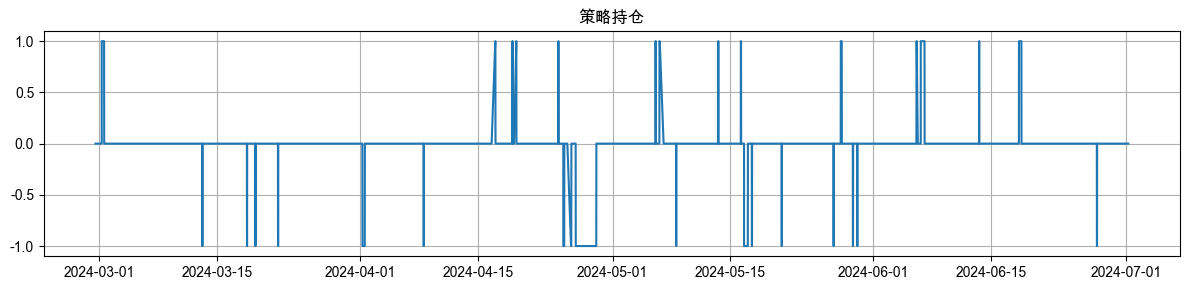

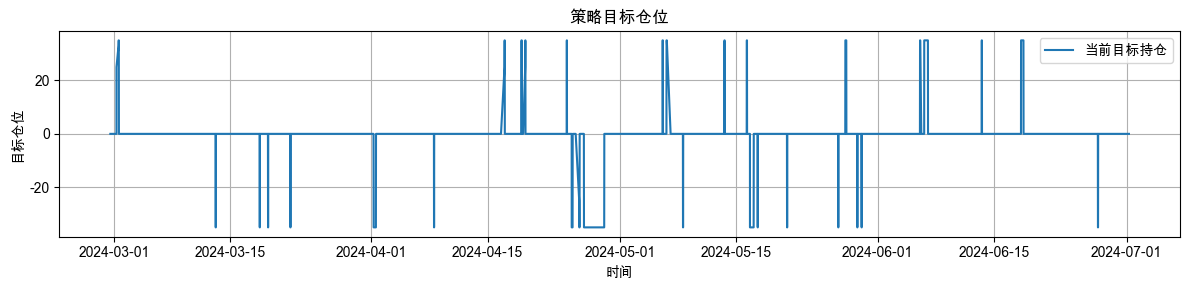

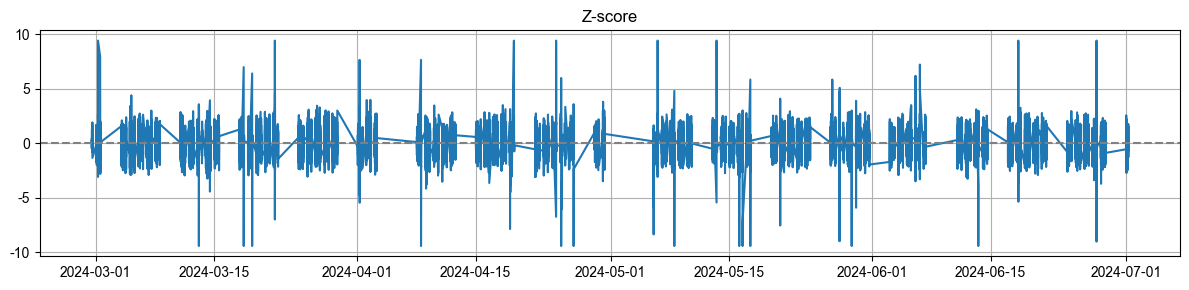

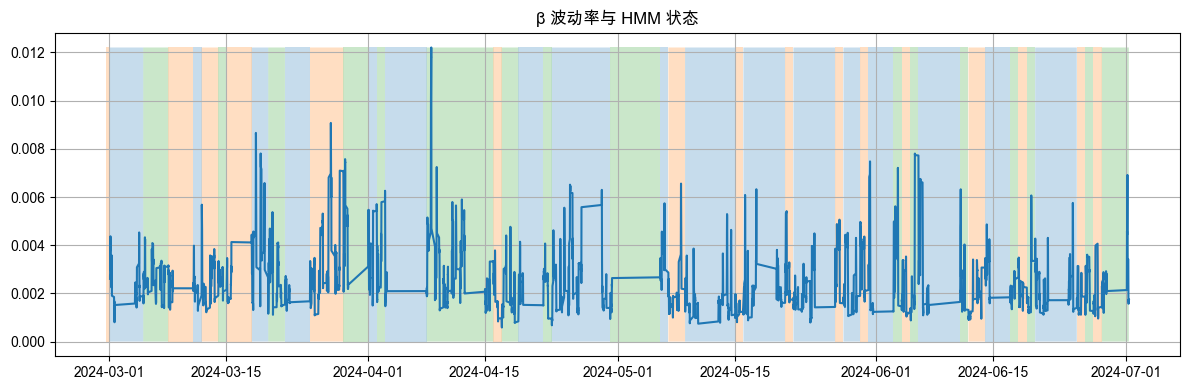

In [5]:
#用分位数筛zscore
import numpy as np
import pandas as pd
from collections import deque
from hmmlearn.hmm import GaussianHMM
from datetime import date
from tqsdk import TqApi, TqAuth, TqBacktest, BacktestFinished, TargetPosTask
from statsmodels.robust.scale import mad
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'  
# plt.rcParams['font.family'] = 'SimHei'    
plt.rcParams['axes.unicode_minus'] = False  

#参数
SYMBOL_Y = "DCE.j2409"
SYMBOL_X = "DCE.jm2409"
OBS_VAR = 0.01
STATE_VAR = 0.0001
Z_WINDOW = 90
STD_WINDOW = 90
MIN_POINTS = 10
N_COMPONENTS = 3
STATE_THRESHOLDS = {0: (3.0, -3.0), 1: (3.5, -3.5), 2: (7.0, -7.0)} 
REVERT_BAND_K = {0: 0.8,1: 1.0,2: 1.5}
STOP_SPREAD = 2.0
BETA_DIFF_THRESH = 0.1
INIT_CAP = 1e7
POS_PCT = 0.05
ENTRY_BAND_ABS = 0.3        # 绝对带宽下限（按你的标的价差量级调整）
ENTRY_BAND_K = 0.5          # 相对带宽系数（乘以开仓时的 MAD）
HOLD_INSIDE_BAND_SEC = 120
STATE_CONFIDENCE_THRESH = 0.5
Z_FILTER_WINDOW = 90
Z_FILTER_Q_LOW = 0.005
Z_FILTER_Q_HIGH = 0.995
REVERT_CONFIRM_BARS = 3
#新增
TRANSITION_PENALTY = 0.12
STATE_BUFFER_LEN = 5
MAJORITY_THRESHOLD = int(STATE_BUFFER_LEN * 0.6)
MIN_HOLD_FOR_SWITCH = 2

#Kalman Filter and zscore
class KalmanStateWithZ:
    def __init__(self, obs_var=OBS_VAR, state_var=STATE_VAR, init_mean=1.0, init_var=1.0, std_window=90):
        self.obs_var = obs_var
        self.state_var = state_var
        self.mean = init_mean
        self.var = init_var
        self.residuals = deque(maxlen=std_window)

    def step(self, y, x):
        pred_mean = self.mean
        pred_var = self.var + self.state_var
        k_gain = pred_var * x / (pred_var * x ** 2 + self.obs_var)
        self.mean = pred_mean + k_gain * (y - pred_mean * x)
        self.var = (1 - k_gain * x) * pred_var
        return self.mean
    
    def update_z(self, y, x):
        beta = self.step(y, x)
        spread = y - beta * x
        self.residuals.append(spread)
        if len(self.residuals) < 10:
            return np.nan, beta
        mu = np.median(self.residuals)
        scale = mad(self.residuals)
        scale = max(scale, 1e-6)
        z = (spread - mu) / scale
        return z, beta

#HMM 训练
def train_hmm_by_minute(df, std_window=60, min_points=10, n_components=3):
    if len(df) < min_points:
        return None
    df['Minute'] = df['datetime'].dt.floor("min")
    dfm = df.groupby('Minute').first().reset_index()
    init_mean = dfm.iloc[0]["close_y"] / dfm.iloc[0]["close_x"]
    kf = KalmanStateWithZ(init_mean=init_mean, std_window=std_window)

    z_list = []
    for _, row in dfm.iterrows():
        z, _ = kf.update_z(row["close_y"], row["close_x"])
        z_list.append(z)

    z_arr = np.array([z for z in z_list if not np.isnan(z)])
    if len(z_arr) < min_points:
        return None

    model = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=100)
    model.fit(z_arr.reshape(-1, 1))
    return model

#主循环
#初始化
api = TqApi(backtest=TqBacktest(start_dt=date(2024, 3, 1), end_dt=date(2024, 7,1)),
            auth=TqAuth("Lawrence-047", "Gzy13802002!"))
quote_y = api.get_quote(SYMBOL_Y)
quote_x = api.get_quote(SYMBOL_X)
klines_y = api.get_kline_serial(SYMBOL_Y, 60, data_length=3000)
klines_x = api.get_kline_serial(SYMBOL_X, 60, data_length=3000)
target_y = TargetPosTask(api, SYMBOL_Y)
target_x = TargetPosTask(api, SYMBOL_X)
pos_y = api.get_position(SYMBOL_Y)
pos_x = api.get_position(SYMBOL_X)

model, kf = None, None
position = 0
entry_z, frozen_beta, entry_time = None, None, None
today = None
prev_z = None
entry_spread = None
entry_center = None
entry_band = None
building_position = False
position_filled = False
current_target_y = 0
current_target_x = 0
rolling_residuals = deque(maxlen=60)
#新增
revert_buffer = deque(maxlen=REVERT_CONFIRM_BARS)
current_confirmed_state = None 
candidate_state = None       # 新状态
candidate_duration = 0       # 状态的持续时间
state_buffer = deque(maxlen=STATE_BUFFER_LEN)
last_exit_time = None
COOLDOWN_SECONDS = 7200

log_times, log_positions, log_zscores, log_states, log_spreads, log_beta = [], [], [], [], [], []
log_target_y = []

try:
    while True:
        api.wait_update()
        if not api.is_changing(klines_y.iloc[-1], "datetime"):
            continue

        now = pd.to_datetime(klines_y.iloc[-1]["datetime"], unit="ns")
        new_day = now.date()
        price_y = klines_y.iloc[-1]["close"]
        price_x = klines_x.iloc[-1]["close"]

        if today != new_day:
            today = new_day
            print(f"\n[{today}] 开盘训练HMM")
            history = pd.DataFrame({
                "datetime": klines_y.datetime / 1e9,
                "close_y": klines_y.close,
                "close_x": klines_x.close,
            }).dropna()
            history["datetime"] = pd.to_datetime(history["datetime"], unit="s")
            history["date"] = history["datetime"].dt.date
            history = history[history["datetime"].dt.date < today]  # 严格避免未来数据
            
            valid_trading_days = sorted(history.groupby("date")["close_y"].count().index)
            recent_5_dates = valid_trading_days[-5:]
            if len(recent_5_dates) < 5:
                print(f"[{today}] HMM训练失败：仅有 {len(recent_5_dates)} 个有效交易日")
                model = None
            else:
                # 只保留过去5个交易日的数据
                history = history[history["date"].isin(recent_5_dates)]

                model = train_hmm_by_minute(history, std_window=STD_WINDOW, min_points=MIN_POINTS, n_components=N_COMPONENTS)
                if model:
                    print(f"[{today}] HMM训练成功")
                else:
                    print(f"[{today}] HMM训练失败")
                    
            kf = KalmanStateWithZ(init_mean=price_y / price_x, std_window=STD_WINDOW)
            
        beta = kf.step(price_y, price_x)
        beta_used = frozen_beta if position != 0 else beta
        spread = price_y - beta_used * price_x
        kf.residuals.append(spread)
        if len(kf.residuals) < MIN_POINTS:
            continue
        mu = np.mean(kf.residuals)
        std = np.std(kf.residuals)
        std = max(std, 1e-6)
        z = (spread - mu) / std
        
        if np.isnan(z) or model is None:
            continue
        
        z_history = list(kf.residuals)
        z_arr = np.array([(s - np.median(z_history)) / (mad(z_history) or 1e-6) for s in z_history])

        if position == 0 and len(z_arr) >= Z_FILTER_WINDOW:
            z_recent = z_arr[-Z_FILTER_WINDOW:]
            q_low = np.quantile(z_recent, Z_FILTER_Q_LOW)
            q_high = np.quantile(z_recent, Z_FILTER_Q_HIGH)

            if z < q_low or z > q_high:
                print(f"[{now}] Z={z:.2f} 超出分位过滤区间（{q_low:.2f} ~ {q_high:.2f}），跳过")
                continue  # 过滤掉极端值

        try:
            state_probs = model.predict_proba(np.array([[z]]))[0]
            if state_probs.max() < STATE_CONFIDENCE_THRESH:
                print(f"[{now}] 状态置信度不足，跳过 z={z:.2f}")
                continue  # 当前模型对状态判断不确定，不执行任何操作

            predicted_state = int(np.argmax(state_probs))
            state_buffer.append(predicted_state)
            # 滑动窗口平滑（去抖）
            state_counts = {s: state_buffer.count(s) for s in set(state_buffer)}
            majority_state = max(state_counts, key=state_counts.get)
            majority_count = state_counts[majority_state]
            
            if state_buffer[-1] == majority_state and majority_count >= MAJORITY_THRESHOLD:
    
                if current_confirmed_state is None:
                    current_confirmed_state = majority_state
                    state = current_confirmed_state
                    
                elif majority_state != current_confirmed_state:
                    prob_old = state_probs[current_confirmed_state]
                    prob_new = state_probs[majority_state]
                    prob_diff = prob_new - prob_old
                    
                    if prob_diff >= TRANSITION_PENALTY:
                        
                        if candidate_state != majority_state:
                            candidate_state = majority_state
                            candidate_duration = 1
                        else:
                            candidate_duration += 1 
                            
                        if candidate_duration >= MIN_HOLD_FOR_SWITCH:
                            current_confirmed_state = candidate_state
                            candidate_state = None
                            candidate_duration = 0   
                    
                    else:
                        # 状态没变，清除候选
                        candidate_state = None
                        candidate_duration = 0
                        
                else:
                    # 状态没变，正常维持
                    candidate_state = None
                    candidate_duration = 0

                state = current_confirmed_state
            
            else:
                continue

        except:
            continue
        open_h, open_l = STATE_THRESHOLDS.get(state, (3.0, -3.0))

        print(f"[{now}] β={beta:.4f}  Z={z:.2f}  状态={state}  Pos={position}")
        
        #记录
        log_times.append(now)
        log_positions.append(position)
        log_zscores.append(z)
        log_states.append(state)
        log_spreads.append(spread)
        log_beta.append(beta_used)
        log_target_y.append(current_target_y)
        rolling_residuals.append(spread)

        #平仓判断
        if position != 0 and entry_time is not None and position_filled:
            curr_spread = price_y - frozen_beta * price_x
            if len(rolling_residuals) >= 10:
                dyn_center = np.median(rolling_residuals)
                mad_now = max(mad(rolling_residuals), 1e-6)
                band_k = REVERT_BAND_K.get(state, 1.0)
                dyn_band = max(ENTRY_BAND_ABS, band_k * mad_now)

                in_band = abs(curr_spread - dyn_center) <= dyn_band
                revert_buffer.append(in_band)

                if len(revert_buffer) == revert_buffer.maxlen:
                    confirm_ratio = sum(revert_buffer) / revert_buffer.maxlen
                    revert_cond = confirm_ratio >= 0.9
                else:
                    revert_cond = False
            drift_cond = abs(beta - frozen_beta) / max(abs(frozen_beta), 1e-12) > BETA_DIFF_THRESH

            if (abs(current_target_y - pos_y.pos) <= max(1, lots * 0.1) and
                abs(current_target_x - pos_x.pos) <= max(1, lots_x * 0.1) and
                (revert_cond or drift_cond)):
        
                current_target_y = 0
                current_target_x = 0
                target_y.set_target_volume(0)
                target_x.set_target_volume(0)
                print("平仓信号")
                position = 0
                entry_z = entry_spread = entry_center = entry_band = frozen_beta = entry_time = None
                building_position = False
                position_filled = False
                rolling_residuals.clear()
                revert_buffer.clear()
                last_exit_time = now

        #滑动调仓逻辑
        if position == 0 and not building_position:
            lots = int(INIT_CAP * POS_PCT / quote_y.margin)
            lots_x = int(lots * beta * price_y * quote_y.volume_multiple / (price_x * quote_x.volume_multiple))

            if last_exit_time is not None and (now - last_exit_time).total_seconds() < COOLDOWN_SECONDS:
                continue
            
            if z < open_l:
                # 多Y 空X
                frozen_beta = beta
                entry_time = now
                entry_spread = price_y - frozen_beta * price_x
                res_arr_open = np.array(kf.residuals)
                mu_open = np.median(res_arr_open)
                mad_open = max(mad(res_arr_open), 1e-6)
                entry_center = mu_open
                entry_band = max(ENTRY_BAND_ABS, ENTRY_BAND_K * mad_open)
                position = 1
                building_position = True
                entry_sign = np.sign(entry_spread - entry_center)
                current_target_y = 0
                current_target_x = 0
                print(f"触发开仓信号：多Y 空X  entry_spread={entry_spread:.4f} center={entry_center:.4f} band={entry_band:.4f}")


            elif z > open_h:
                # 空Y 多X
                frozen_beta = beta
                entry_time = now
                entry_spread = price_y - frozen_beta * price_x
                res_arr_open = np.array(kf.residuals)
                mu_open = np.median(res_arr_open)
                mad_open = max(mad(res_arr_open), 1e-6)
                entry_center = mu_open
                entry_band = max(ENTRY_BAND_ABS, ENTRY_BAND_K * mad_open)
                position = -1
                building_position = True
                entry_sign = np.sign(entry_spread - entry_center)
                current_target_y = 0
                current_target_x = 0
                print(f"触发开仓信号：空Y 多X  entry_spread={entry_spread:.4f} center={entry_center:.4f} band={entry_band:.4f}")
                
        if building_position and frozen_beta is not None:
            alpha = 0.7
            early_fill_threshold = 0.7
            lots = int(INIT_CAP * POS_PCT / quote_y.margin)
            lots_x = int(lots * frozen_beta * price_y * quote_y.volume_multiple / (price_x * quote_x.volume_multiple))

            if position == 1:
                current_target_y = int(alpha * lots + (1 - alpha) * current_target_y)
                current_target_x = int(-alpha * lots_x + (1 - alpha) * current_target_x)
            elif position == -1:
                current_target_y = int(-alpha * lots + (1 - alpha) * current_target_y)
                current_target_x = int(alpha * lots_x + (1 - alpha) * current_target_x)

            target_y.set_target_volume(current_target_y)
            target_x.set_target_volume(current_target_x)

            # 判断是否建仓完成
            if (abs(current_target_y - pos_y.pos) <= max(1, lots * 0.1) and
                abs(current_target_x - pos_x.pos) <= max(1, lots_x * 0.1)):
                building_position = False
                position_filled = True # 终止建仓期
                
            else:
                # 判断是否达到提前完成标准（如达到 50% 以上）
                pct_y = abs(pos_y.pos) / max(abs(current_target_y), 1)
                pct_x = abs(pos_x.pos) / max(abs(current_target_x), 1)
                if pct_y > early_fill_threshold and pct_x > early_fill_threshold:
                    position_filled = True  # 允许平仓逻辑执行

except BacktestFinished:
    print("回测结束")
    api.close()

    df_plot = pd.DataFrame({
        "time": log_times,
        "position": log_positions,
        "zscore": log_zscores,
        "state": log_states,
        "spread": log_spreads,
        "beta": log_beta,
        "current_target_y": log_target_y
    })
    df_plot["beta_std"] = df_plot["beta"].rolling(window=90).std()

    plt.figure(figsize=(12, 3))
    plt.plot(df_plot["time"], df_plot["position"])
    plt.title("策略持仓")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 3))
    plt.plot(df_plot['time'], df_plot['current_target_y'], label='当前目标持仓')
    plt.title('策略目标仓位')
    plt.xlabel('时间')
    plt.ylabel('目标仓位')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 3))
    plt.plot(df_plot["time"], df_plot["zscore"], label="Z-score")
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Z-score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(df_plot["time"], df_plot["beta_std"], label="Rolling β Std")
    for s in sorted(df_plot["state"].unique()):
        mask = df_plot["state"] == s
        plt.fill_between(df_plot["time"], 0, df_plot["beta_std"].max(), where=mask,
                         alpha=0.25)
    plt.title("β 波动率与 HMM 状态")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[2024-02-29] 开盘训练HMM
[2024-02-29] HMM训练成功
[2024-02-29 13:11:00] β=1.3409  Z=0.52  状态=1  Pos=0
[2024-02-29 13:12:00] β=1.3391  Z=-0.41  状态=1  Pos=0
[2024-02-29 13:13:00] β=1.3391  Z=0.18  状态=1  Pos=0
[2024-02-29 13:14:00] β=1.3384  Z=-0.08  状态=1  Pos=0
[2024-02-29 13:15:00] β=1.3383  Z=0.13  状态=1  Pos=0
[2024-02-29 13:16:00] β=1.3394  Z=0.52  状态=1  Pos=0
[2024-02-29 13:17:00] β=1.3373  Z=-0.58  状态=1  Pos=0
[2024-02-29 13:18:00] β=1.3372  Z=0.13  状态=1  Pos=0
[2024-02-29 13:19:00] β=1.3356  Z=-0.40  状态=1  Pos=0
[2024-02-29 13:20:00] β=1.3340  Z=-0.38  状态=1  Pos=0
[2024-02-29 13:21:00] β=1.3325  Z=-0.34  状态=1  Pos=0
[2024-02-29 13:22:00] β=1.3342  Z=0.85  状态=1  Pos=0
[2024-02-29 13:23:00] β=1.3331  Z=-0.19  状态=1  Pos=0
[2024-02-29 13:24:00] β=1.3338  Z=0.46  状态=1  Pos=0
[2024-02-29 13:25:00] β=1.3357  Z=0.91  状态=1  Pos=0
[2024-02-29 13:26:00] β=1.3341  Z=-0.47  状态=1  Pos=0
[2024-02-29 13:27:00] β=1.3337  Z=0.03  状态=1  Pos=0
[2024-02-29 13:28:00] β=1.3326  Z=-0.28  状态=1  Pos=0
[2024-02-29 

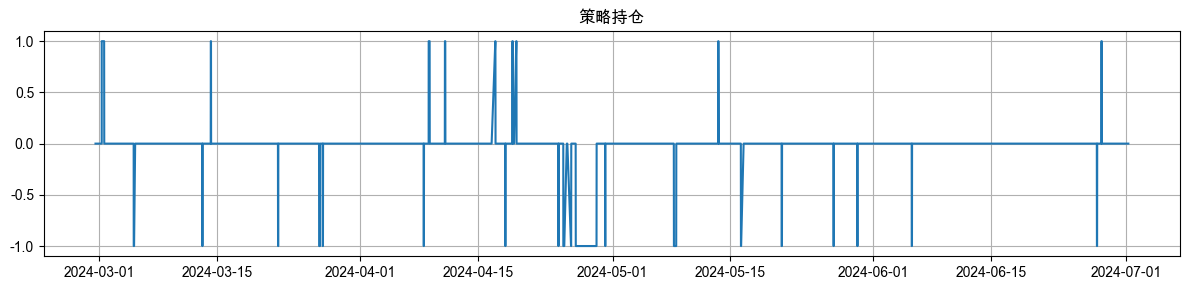

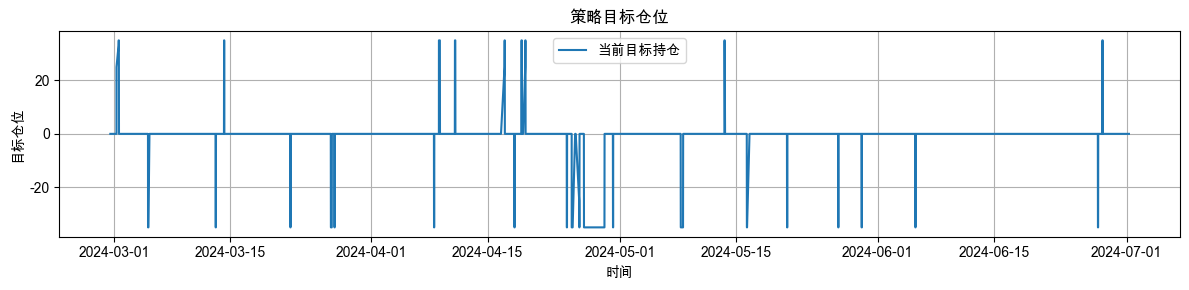

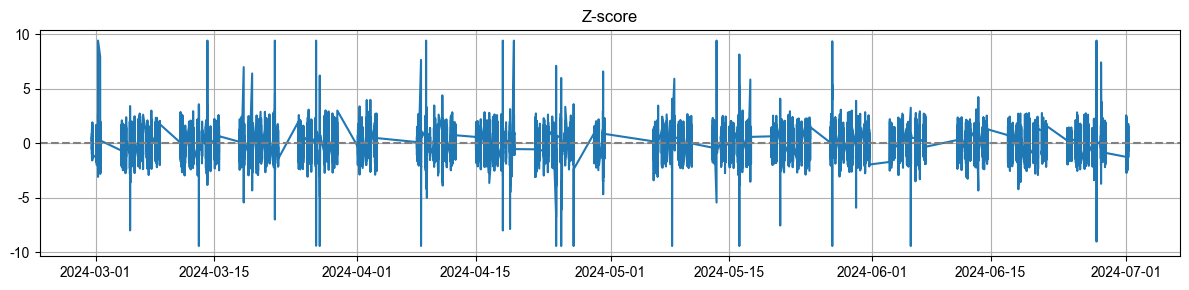

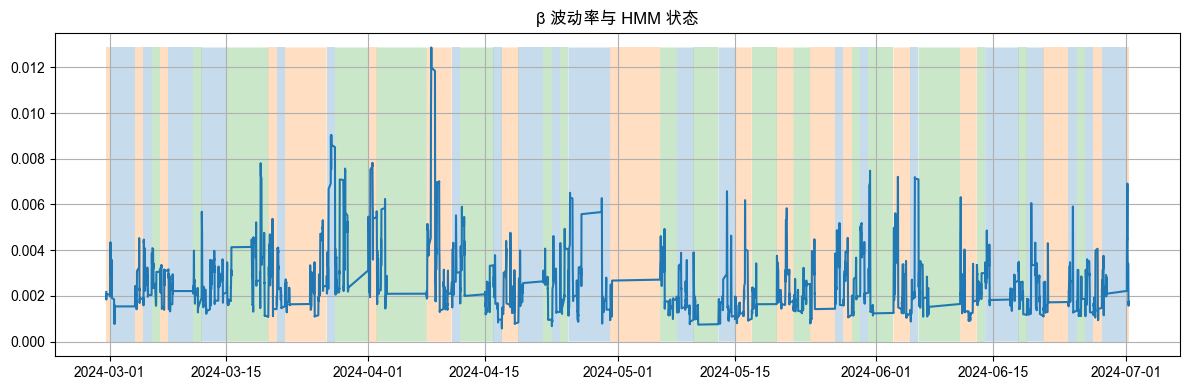

In [10]:
#另一平仓逻辑，开仓后重新估计
import numpy as np
import pandas as pd
from collections import deque
from hmmlearn.hmm import GaussianHMM
from datetime import date
from tqsdk import TqApi, TqAuth, TqBacktest, BacktestFinished, TargetPosTask
from statsmodels.robust.scale import mad
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'  
# plt.rcParams['font.family'] = 'SimHei'    
plt.rcParams['axes.unicode_minus'] = False  

#参数
SYMBOL_Y = "DCE.j2409"
SYMBOL_X = "DCE.jm2409"
OBS_VAR = 0.01
STATE_VAR = 0.0001
Z_WINDOW = 90
STD_WINDOW = 90
MIN_POINTS = 10
N_COMPONENTS = 3
STATE_THRESHOLDS = {0: (3.0, -3.0), 1: (3.5, -3.5), 2: (7.0, -7.0)} 
STOP_SPREAD = 2.0
BETA_DIFF_THRESH = 0.1
INIT_CAP = 1e7
POS_PCT = 0.05
ENTRY_BAND_ABS = 0.3        # 绝对带宽下限（按你的标的价差量级调整）
ENTRY_BAND_K = 0.5          # 相对带宽系数（乘以开仓时的 MAD）
HOLD_INSIDE_BAND_SEC = 120
STATE_CONFIDENCE_THRESH = 0.5
Z_FILTER_WINDOW = 90
Z_FILTER_Q_LOW = 0.005
Z_FILTER_Q_HIGH = 0.995
REVERT_CONFIRM_BARS = 3
TRANSITION_PENALTY = 0.12
STATE_BUFFER_LEN = 5
MAJORITY_THRESHOLD = int(STATE_BUFFER_LEN * 0.6)
MIN_HOLD_FOR_SWITCH = 2
#新增
holding_residuals = deque(maxlen=60)
HOLD_MIN_SECONDS = 600
MIN_HOLDING_RESIDUALS = 50
COOLDOWN_SECONDS = 7200

#Kalman Filter and zscore
class KalmanStateWithZ:
    def __init__(self, obs_var=OBS_VAR, state_var=STATE_VAR, init_mean=1.0, init_var=1.0, std_window=90):
        self.obs_var = obs_var
        self.state_var = state_var
        self.mean = init_mean
        self.var = init_var
        self.residuals = deque(maxlen=std_window)

    def step(self, y, x):
        pred_mean = self.mean
        pred_var = self.var + self.state_var
        k_gain = pred_var * x / (pred_var * x ** 2 + self.obs_var)
        self.mean = pred_mean + k_gain * (y - pred_mean * x)
        self.var = (1 - k_gain * x) * pred_var
        return self.mean
    
    def update_z(self, y, x):
        beta = self.step(y, x)
        spread = y - beta * x
        self.residuals.append(spread)
        if len(self.residuals) < 10:
            return np.nan, beta
        mu = np.median(self.residuals)
        scale = mad(self.residuals)
        scale = max(scale, 1e-6)
        z = (spread - mu) / scale
        return z, beta

#HMM 训练
def train_hmm_by_minute(df, std_window=60, min_points=10, n_components=3):
    if len(df) < min_points:
        return None
    df['Minute'] = df['datetime'].dt.floor("min")
    dfm = df.groupby('Minute').first().reset_index()
    init_mean = dfm.iloc[0]["close_y"] / dfm.iloc[0]["close_x"]
    kf = KalmanStateWithZ(init_mean=init_mean, std_window=std_window)

    z_list = []
    for _, row in dfm.iterrows():
        z, _ = kf.update_z(row["close_y"], row["close_x"])
        z_list.append(z)

    z_arr = np.array([z for z in z_list if not np.isnan(z)])
    if len(z_arr) < min_points:
        return None

    model = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=100)
    model.fit(z_arr.reshape(-1, 1))
    return model

#主循环
#初始化
api = TqApi(backtest=TqBacktest(start_dt=date(2024, 3, 1), end_dt=date(2024, 7,1)),
            auth=TqAuth("Lawrence-047", "Gzy13802002!"))
quote_y = api.get_quote(SYMBOL_Y)
quote_x = api.get_quote(SYMBOL_X)
klines_y = api.get_kline_serial(SYMBOL_Y, 60, data_length=3000)
klines_x = api.get_kline_serial(SYMBOL_X, 60, data_length=3000)
target_y = TargetPosTask(api, SYMBOL_Y)
target_x = TargetPosTask(api, SYMBOL_X)
pos_y = api.get_position(SYMBOL_Y)
pos_x = api.get_position(SYMBOL_X)

model, kf = None, None
position = 0
entry_z, frozen_beta, entry_time = None, None, None
today = None
prev_z = None
entry_spread = None
entry_center = None
entry_band = None
building_position = False
position_filled = False
current_target_y = 0
current_target_x = 0
rolling_residuals = deque(maxlen=60)
#新增
revert_buffer = deque(maxlen=REVERT_CONFIRM_BARS)
current_confirmed_state = None 
candidate_state = None       # 候选新状态
candidate_duration = 0       # 候选状态的持续时间
state_buffer = deque(maxlen=STATE_BUFFER_LEN)
last_exit_time = None


log_times, log_positions, log_zscores, log_states, log_spreads, log_beta = [], [], [], [], [], []
log_target_y = []

try:
    while True:
        api.wait_update()
        if not api.is_changing(klines_y.iloc[-1], "datetime"):
            continue

        now = pd.to_datetime(klines_y.iloc[-1]["datetime"], unit="ns")
        new_day = now.date()
        price_y = klines_y.iloc[-1]["close"]
        price_x = klines_x.iloc[-1]["close"]

        if today != new_day:
            today = new_day
            print(f"\n[{today}] 开盘训练HMM")
            history = pd.DataFrame({
                "datetime": klines_y.datetime / 1e9,
                "close_y": klines_y.close,
                "close_x": klines_x.close,
            }).dropna()
            history["datetime"] = pd.to_datetime(history["datetime"], unit="s")
            history["date"] = history["datetime"].dt.date
            history = history[history["datetime"].dt.date < today]  # 严格避免未来数据
            
            valid_trading_days = sorted(history.groupby("date")["close_y"].count().index)
            recent_5_dates = valid_trading_days[-5:]
            if len(recent_5_dates) < 5:
                print(f"[{today}] HMM训练失败：仅有 {len(recent_5_dates)} 个有效交易日")
                model = None
            else:
                # 只保留过去5个交易日的数据
                history = history[history["date"].isin(recent_5_dates)]

                model = train_hmm_by_minute(history, std_window=STD_WINDOW, min_points=MIN_POINTS, n_components=N_COMPONENTS)
                if model:
                    print(f"[{today}] HMM训练成功")
                else:
                    print(f"[{today}] HMM训练失败")
                    
            kf = KalmanStateWithZ(init_mean=price_y / price_x, std_window=STD_WINDOW)
            
        beta = kf.step(price_y, price_x)
        beta_used = frozen_beta if position != 0 else beta
        spread = price_y - beta_used * price_x
        kf.residuals.append(spread)
        
        if position != 0 and frozen_beta is not None:
            curr_residual = price_y - frozen_beta * price_x
            holding_residuals.append(curr_residual)
            
        if len(kf.residuals) < MIN_POINTS:
            continue
        mu = np.mean(kf.residuals)
        std = np.std(kf.residuals)
        std = max(std, 1e-6)
        z = (spread - mu) / std
        
        if np.isnan(z) or model is None:
            continue
        
        z_history = list(kf.residuals)
        z_arr = np.array([(s - np.median(z_history)) / (mad(z_history) or 1e-6) for s in z_history])

        if position == 0 and len(z_arr) >= Z_FILTER_WINDOW:
            z_recent = z_arr[-Z_FILTER_WINDOW:]
            q_low = np.quantile(z_recent, Z_FILTER_Q_LOW)
            q_high = np.quantile(z_recent, Z_FILTER_Q_HIGH)

            if z < q_low or z > q_high:
                print(f"[{now}] Z={z:.2f} 超出分位过滤区间（{q_low:.2f} ~ {q_high:.2f}），跳过")
                continue  # 过滤掉极端值

        try:
            state_probs = model.predict_proba(np.array([[z]]))[0]
            if state_probs.max() < STATE_CONFIDENCE_THRESH:
                print(f"[{now}] 状态置信度不足，跳过 z={z:.2f}")
                continue  # 当前模型对状态判断不确定，不执行任何操作

            predicted_state = int(np.argmax(state_probs))
            state_buffer.append(predicted_state)
            # 滑动窗口平滑（去抖）
            state_counts = {s: state_buffer.count(s) for s in set(state_buffer)}
            majority_state = max(state_counts, key=state_counts.get)
            majority_count = state_counts[majority_state]
            
            if state_buffer[-1] == majority_state and majority_count >= MAJORITY_THRESHOLD:
    
                if current_confirmed_state is None:
                    current_confirmed_state = majority_state
                    state = current_confirmed_state
                    
                elif majority_state != current_confirmed_state:
                    prob_old = state_probs[current_confirmed_state]
                    prob_new = state_probs[majority_state]
                    prob_diff = prob_new - prob_old
                    
                    if prob_diff >= TRANSITION_PENALTY:
                        
                        if candidate_state != majority_state:
                            candidate_state = majority_state
                            candidate_duration = 1
                        else:
                            candidate_duration += 1 
                            
                        if candidate_duration >= MIN_HOLD_FOR_SWITCH:
                            current_confirmed_state = candidate_state
                            candidate_state = None
                            candidate_duration = 0   
                    
                    else:
                        # 状态没变，清除候选
                        candidate_state = None
                        candidate_duration = 0
                        
                else:
                    # 状态没变，正常维持
                    candidate_state = None
                    candidate_duration = 0

                state = current_confirmed_state
            
            else:
                continue

        except:
            continue
        open_h, open_l = STATE_THRESHOLDS.get(state, (3.0, -3.0))

        print(f"[{now}] β={beta:.4f}  Z={z:.2f}  状态={state}  Pos={position}")
        
        #记录
        log_times.append(now)
        log_positions.append(position)
        log_zscores.append(z)
        log_states.append(state)
        log_spreads.append(spread)
        log_beta.append(beta_used)
        log_target_y.append(current_target_y)
        rolling_residuals.append(spread)

        #平仓判断
        if position != 0 and entry_time is not None and position_filled:
            hold_time = (now - entry_time).total_seconds()
            curr_spread = price_y - frozen_beta * price_x
            revert_cond = False
            # 只有当持仓时间足够长且样本足够多，才触发判断
            if hold_time >= HOLD_MIN_SECONDS and len(holding_residuals) >= MIN_HOLDING_RESIDUALS:
                band_low_pct, band_high_pct = {0: (45, 55), 1: (40, 60),  2: (30, 70)}.get(state, (40, 60))
                center_low, center_high = np.percentile(holding_residuals, [band_low_pct, band_high_pct])
                if entry_spread >= center_high:
                    # 开仓在右尾：回归需穿越至中心区下沿
                    revert_cond = curr_spread <= center_high
                elif entry_spread <= center_low:
                    # 开仓在左尾：回归需穿越至中心区上沿
                    revert_cond = curr_spread >= center_low
                    
            drift_cond = abs(beta - frozen_beta) / max(abs(frozen_beta), 1e-12) > BETA_DIFF_THRESH

            if (abs(current_target_y - pos_y.pos) <= max(1, lots * 0.1) and
                abs(current_target_x - pos_x.pos) <= max(1, lots_x * 0.1) and
                (revert_cond or drift_cond)):
                if revert_cond:
                    print(f"[{now}] 回归平仓触发（状态={state} 中心=({band_low_pct}-{band_high_pct})%）")
                elif drift_cond:
                    print(f"[{now}] β漂移触发（当前β={beta:.4f} 冻结β={frozen_beta:.4f}）")
                current_target_y = 0
                current_target_x = 0
                target_y.set_target_volume(0)
                target_x.set_target_volume(0)
                last_exit_time = now
                print("平仓信号")
                position = 0
                entry_z = entry_spread = entry_center = entry_band = frozen_beta = entry_time = None
                building_position = False
                position_filled = False
                rolling_residuals.clear()
                revert_buffer.clear()
                last_exit_time = now

        #滑动调仓
        if position == 0 and not building_position:
            
            if last_exit_time is not None and (now - last_exit_time).total_seconds() < COOLDOWN_SECONDS:
                print(f"[{now}] 冷却期未结束，禁止开仓")
                continue
            lots = int(INIT_CAP * POS_PCT / quote_y.margin)
            lots_x = int(lots * beta * price_y * quote_y.volume_multiple / (price_x * quote_x.volume_multiple))
            
            if z < open_l:
                # 多Y 空X
                frozen_beta = beta
                entry_time = now
                entry_spread = price_y - frozen_beta * price_x
                res_arr_open = np.array(kf.residuals)
                mu_open = np.median(res_arr_open)
                mad_open = max(mad(res_arr_open), 1e-6)
                entry_center = mu_open
                entry_band = max(ENTRY_BAND_ABS, ENTRY_BAND_K * mad_open)
                position = 1
                building_position = True
                entry_sign = np.sign(entry_spread - entry_center)
                holding_residuals.clear()
                current_target_y = 0
                current_target_x = 0
                print(f"触发开仓信号：多Y 空X  entry_spread={entry_spread:.4f} center={entry_center:.4f} band={entry_band:.4f}")


            elif z > open_h:
                # 空Y 多X
                frozen_beta = beta
                entry_time = now
                entry_spread = price_y - frozen_beta * price_x
                res_arr_open = np.array(kf.residuals)
                mu_open = np.median(res_arr_open)
                mad_open = max(mad(res_arr_open), 1e-6)
                entry_center = mu_open
                entry_band = max(ENTRY_BAND_ABS, ENTRY_BAND_K * mad_open)
                position = -1
                building_position = True
                entry_sign = np.sign(entry_spread - entry_center)
                holding_residuals.clear()
                current_target_y = 0
                current_target_x = 0
                print(f"触发开仓信号：空Y 多X  entry_spread={entry_spread:.4f} center={entry_center:.4f} band={entry_band:.4f}")
                
        if building_position and frozen_beta is not None:
            alpha = 0.7
            early_fill_threshold = 0.7
            lots = int(INIT_CAP * POS_PCT / quote_y.margin)
            lots_x = int(lots * frozen_beta * price_y * quote_y.volume_multiple / (price_x * quote_x.volume_multiple))

            if position == 1:
                current_target_y = int(alpha * lots + (1 - alpha) * current_target_y)
                current_target_x = int(-alpha * lots_x + (1 - alpha) * current_target_x)
            elif position == -1:
                current_target_y = int(-alpha * lots + (1 - alpha) * current_target_y)
                current_target_x = int(alpha * lots_x + (1 - alpha) * current_target_x)

            target_y.set_target_volume(current_target_y)
            target_x.set_target_volume(current_target_x)

            # 判断是否建仓完成
            if (abs(current_target_y - pos_y.pos) <= max(1, lots * 0.1) and
                abs(current_target_x - pos_x.pos) <= max(1, lots_x * 0.1)):
                building_position = False
                position_filled = True # 终止建仓期
                
            else:
                # 判断是否达到提前完成标准（如达到 50% 以上）
                pct_y = abs(pos_y.pos) / max(abs(current_target_y), 1)
                pct_x = abs(pos_x.pos) / max(abs(current_target_x), 1)
                if pct_y > early_fill_threshold and pct_x > early_fill_threshold:
                    position_filled = True  # 允许平仓逻辑执行

except BacktestFinished:
    print("回测结束")
    api.close()

    df_plot = pd.DataFrame({
        "time": log_times,
        "position": log_positions,
        "zscore": log_zscores,
        "state": log_states,
        "spread": log_spreads,
        "beta": log_beta,
        "current_target_y": log_target_y
    })
    df_plot["beta_std"] = df_plot["beta"].rolling(window=90).std()

    plt.figure(figsize=(12, 3))
    plt.plot(df_plot["time"], df_plot["position"])
    plt.title("策略持仓")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 3))
    plt.plot(df_plot['time'], df_plot['current_target_y'], label='当前目标持仓')
    plt.title('策略目标仓位')
    plt.xlabel('时间')
    plt.ylabel('目标仓位')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 3))
    plt.plot(df_plot["time"], df_plot["zscore"], label="Z-score")
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Z-score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(df_plot["time"], df_plot["beta_std"], label="Rolling β Std")
    for s in sorted(df_plot["state"].unique()):
        mask = df_plot["state"] == s
        plt.fill_between(df_plot["time"], 0, df_plot["beta_std"].max(), where=mask,
                         alpha=0.25)
    plt.title("β 波动率与 HMM 状态")
    plt.grid(True)
    plt.tight_layout()
    plt.show()